In [1]:
import numpy as np 
import pandas as pd
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
EPOCHS=20
BATCH_SIZE=32
HEIGHT=256
WIDTH=256
CHANNELS=3
N_CLASSES=13
AUTO = tf.data.AUTOTUNE

def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH * 2])

    # Split into image and mask
    image_part = image[:, :WIDTH, :]
    mask_part = image[:, WIDTH:, 0] * 255.0  # scale if needed

    # Binning mask
    bins = tf.constant([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240], dtype=tf.float32)
    mask_binned = tf.reduce_sum(tf.cast(tf.greater(mask_part[..., tf.newaxis], bins), tf.int32), axis=-1)

    return image_part, mask_binned  

def get_dataset(file_list, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_list))
    dataset = dataset.map(process_path, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

train_filenames = glob.glob("/Users/saptarshimallikthakur/Desktop/cityscapes_data/train/*.jpg")
val_filenames = glob.glob("/Users/saptarshimallikthakur/Desktop/cityscapes_data/val/*.jpg")

train_dataset = get_dataset(train_filenames)
val_dataset = get_dataset(val_filenames, shuffle=False)

# Get one batch from tf.data.Dataset
for imgs, segs in train_dataset.take(1):
    imgs_np = imgs.numpy()
    segs_np = segs.numpy()
    break

imgs.shape, segs.shape

2025-07-09 18:54:36.026322: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-09 18:54:36.026373: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-09 18:54:36.026377: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1752067476.026388 4175942 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752067476.026405 4175942 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(TensorShape([32, 256, 256, 3]), TensorShape([32, 256, 256]))

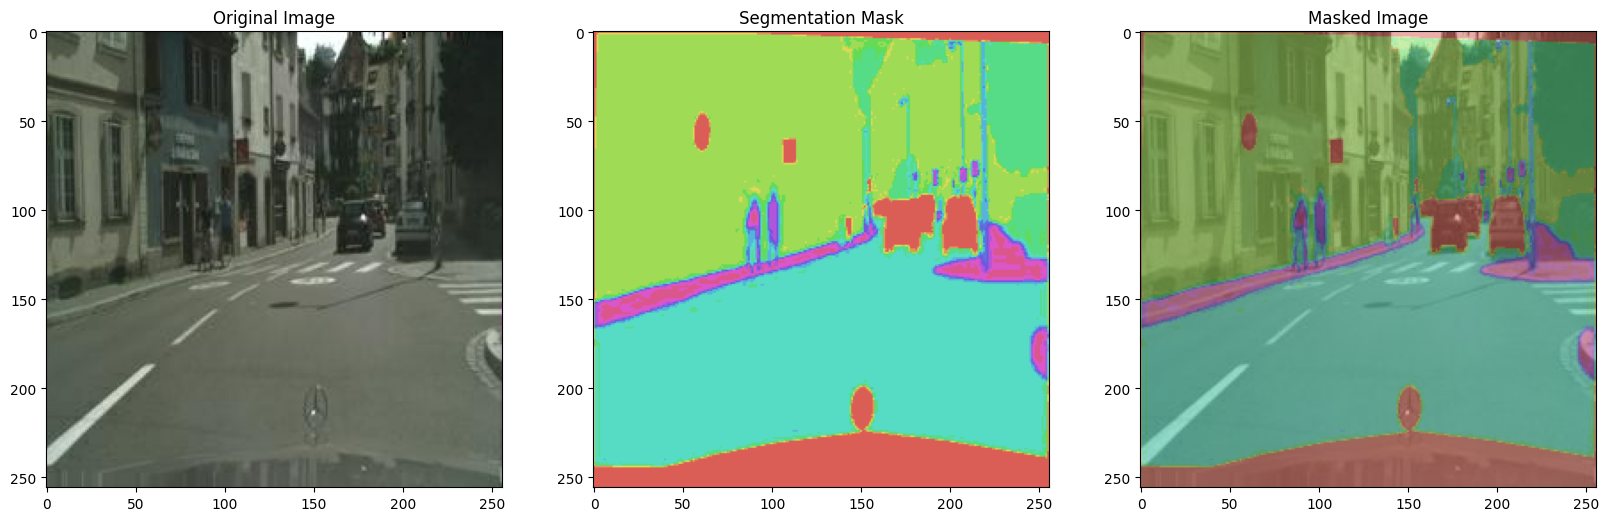

In [3]:
def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# Visualize the first item in batch
image = imgs_np[0]                             # shape: (256, 256, 3)
mask = give_color_to_seg_img(segs_np[0])
masked_image = image * 0.5 + mask * 0.5        # overlay

# Plot
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class OverlapPatchEmbeddings(layers.Layer):
    """
    Layer that creates overlapping patch embeddings from input images using Conv2D.

    Args:
        patch_size (int): Size of the convolution kernel. Determines patch size.
        stride (int): Stride for convolution. Controls patch overlap.
        embedding_dim (int): Number of output channels for embedding.
        name (str): Optional name for the layer.
    """
    def __init__(self, patch_size=7, stride=4, embedding_dim=16, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.conv = layers.Conv2D(
            filters=embedding_dim,
            kernel_size=patch_size,
            strides=stride,
            padding="same",
            name="patch_embed_conv"
        )
        self.norm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs):
        """
        Apply convolution and layer normalization to generate patch embeddings.

        Args:
            inputs (Tensor): Input tensor of shape (batch_size, H, W, C).

        Returns:
            Tensor: Patch embeddings of shape (batch_size, H/stride, W/stride, embedding_dim).
        """
        x = self.conv(inputs)
        x = self.norm(x)
        return x

# --- Step 2.1: Define the Efficient Self-Attention Layer ---
class EfficientSelfAttention(layers.Layer):
    """
    Efficient Self-Attention with optional spatial reduction.

    Args:
        num_heads (int): Number of attention heads.
        embedding_dim (int): Total embedding dimension (must be divisible by num_heads).
        sr_ratio (int): Spatial reduction ratio for K/V (sr_ratio > 1 enables reduction).
        name (str): Optional name for the layer.
    """
    def __init__(self, num_heads, embedding_dim, sr_ratio=1, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        
        if embedding_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by number of heads.")
        
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.head_dim = embedding_dim // num_heads
        self.sr_ratio = sr_ratio

        # Projections for query, key, value
        self.q_proj = layers.Dense(embedding_dim, name="q_proj")
        self.k_proj = layers.Dense(embedding_dim, name="k_proj")
        self.v_proj = layers.Dense(embedding_dim, name="v_proj")
        self.out_proj = layers.Dense(embedding_dim, name="out_proj")

        self.attn_drop = layers.Dropout(0.1)
        self.proj_drop = layers.Dropout(0.1)

        # Sequence reduction
        if sr_ratio > 1:
            self.sr_conv = layers.Conv2D(
                filters=embedding_dim,
                kernel_size=sr_ratio,
                strides=sr_ratio,
                padding="same",
                name="sr_conv"
            )
            self.sr_norm = layers.LayerNormalization(epsilon=1e-5, name="sr_norm")

    def call(self, x, H, W):
        """
        Args:
            x (Tensor): Input tensor of shape (B, N=H*W, C).
            H (int): Height of the original spatial feature map.
            W (int): Width of the original spatial feature map.

        Returns:
            Tensor: Output of shape (B, N, C) after self-attention.
        """
        B, N = tf.shape(x)[0], tf.shape(x)[1]

        # === 1. Query projection ===
        q = self.q_proj(x)                                      # (B, N, C)
        q = tf.reshape(q, [B, N, self.num_heads, self.head_dim])
        q = tf.transpose(q, [0, 2, 1, 3])                        # (B, heads, N, head_dim)

        # === 2. Spatial Reduction (for K/V) ===
        if self.sr_ratio > 1:
            x_2d = tf.reshape(x, [B, H, W, self.embedding_dim])        # (B, H, W, C)
            x_reduced = self.sr_conv(x_2d)                             # (B, H//sr, W//sr, C)
            x_reduced = tf.reshape(x_reduced, [B, -1, self.embedding_dim])
            kv_input = self.sr_norm(x_reduced)                         # (B, N_kv, C)
        else:
            kv_input = x  # No spatial reduction

        # === 3. Key and Value projections ===
        k = self.k_proj(kv_input)
        v = self.v_proj(kv_input)

        k = tf.reshape(k, [B, -1, self.num_heads, self.head_dim])
        k = tf.transpose(k, [0, 2, 3, 1])  # (B, heads, head_dim, N_kv)

        v = tf.reshape(v, [B, -1, self.num_heads, self.head_dim])
        v = tf.transpose(v, [0, 2, 1, 3])  # (B, heads, N_kv, head_dim)

        # === 4. Scaled Dot-Product Attention ===
        scale = tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attn_scores = tf.matmul(q, k) / scale                     # (B, heads, N, N_kv)
        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attn_weights = self.attn_drop(attn_weights)

        attn_output = tf.matmul(attn_weights, v)                 # (B, heads, N, head_dim)

        # === 5. Recombine heads and final projection ===
        attn_output = tf.transpose(attn_output, [0, 2, 1, 3])    # (B, N, heads, head_dim)
        attn_output = tf.reshape(attn_output, [B, N, self.embedding_dim])
        attn_output = self.out_proj(attn_output)
        return self.proj_drop(attn_output)
    
# --- Step 2.2: Define the Mix-FFN Layer ---
class MixFFN(layers.Layer):
    """
    Mix-FeedForward Network (Mix-FFN) layer with spatial mixing using depthwise convolution.

    Args:
        embedding_dim (int): Input and output embedding dimension.
        expansion_factor (int): Multiplier to expand embedding dimension in the intermediate layer.
        name (str): Optional name for the layer.
    """
    def __init__(self, embedding_dim, expansion_factor=4, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.hidden_dim = embedding_dim * expansion_factor

        # First MLP layer (expansion)
        self.mlp1 = layers.Dense(self.hidden_dim, name="mlp1")

        # Depthwise separable convolution for positional encoding effect
        self.conv = layers.DepthwiseConv2D(kernel_size=3,strides=1,padding="same",name="dw_conv")

        # Activation and regularization
        self.act = layers.Activation("gelu")
        self.mlp2 = layers.Dense(embedding_dim, name="mlp2")
        self.drop = layers.Dropout(0.1)

    def call(self, x, H, W):
        """
        Forward pass of MixFFN.

        Args:
            x (Tensor): Input tensor of shape (B, N, C), where N = H × W.
            H (int): Height of spatial grid.
            W (int): Width of spatial grid.

        Returns:
            Tensor: Output tensor of shape (B, N, C).
        """
        B, N, C = tf.unstack(tf.shape(x))

        # 1. First linear layer
        x_proj = self.mlp1(x)  # (B, N, hidden_dim)

        # 2. Reshape to spatial form and apply 3x3 conv
        x_spatial = tf.reshape(x_proj, [B, H, W, self.hidden_dim])
        x_conv = self.conv(x_spatial)

        # 3. Flatten spatial output back to sequence
        x_flat = tf.reshape(x_conv, [B, N, self.hidden_dim])

        # 4. Activation → second linear layer → dropout
        x_out = self.act(x_flat)
        x_out = self.mlp2(x_out)
        return self.drop(x_out)

    
# --- Step 2.3: Define the main Transformer Block ---
class TransformerBlock(layers.Layer):
    """
    Transformer block consisting of:
    1. LayerNorm → Efficient Self-Attention → Residual
    2. LayerNorm → Mix-FeedForward Network → Residual

    Args:
        num_heads (int): Number of attention heads.
        embedding_dim (int): Embedding dimension.
        sr_ratio (int): Spatial reduction ratio for attention.
        expansion_factor (int): Expansion factor for FFN.
        name (str): Optional name for the block.
    """
    def __init__(self, num_heads, embedding_dim, sr_ratio, expansion_factor, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        
        # LayerNorm + Attention
        self.norm1 = layers.LayerNormalization(epsilon=1e-5, name="norm1")
        self.attn = EfficientSelfAttention(
            num_heads=num_heads,
            embedding_dim=embedding_dim,
            sr_ratio=sr_ratio,
            name="attention"
        )

        # LayerNorm + FFN
        self.norm2 = layers.LayerNormalization(epsilon=1e-5, name="norm2")
        self.ffn = MixFFN(
            embedding_dim=embedding_dim,
            expansion_factor=expansion_factor,
            name="ffn"
        )

    def call(self, x, H, W):
        """
        Args:
            x (Tensor): Input tensor of shape (B, N, C).
            H (int): Height of spatial feature map.
            W (int): Width of spatial feature map.

        Returns:
            Tensor: Output tensor of shape (B, N, C).
        """
        # === Attention Block ===
        x_attn = self.norm1(x)
        x = x + self.attn(x_attn, H, W)

        # === FFN Block ===
        x_ffn = self.norm2(x)
        x = x + self.ffn(x_ffn, H, W)

        return x

class MiTEncoder(layers.Layer):
    """
    MiT (Mix Transformer) Encoder with 4 stages.

    Each stage:
    - Applies overlap patch embedding (with downsampling)
    - Processes with 2 Transformer blocks
    - Stores output feature maps for decoder
    """
    def __init__(self, embedding_dims, num_heads, sr_ratios, expansion_factors, name="mit_encoder", **kwargs):
        super().__init__(name=name, **kwargs)

        # Stage 1
        self.overlap0 = OverlapPatchEmbeddings(patch_size=7, stride=4, embedding_dim=embedding_dims[0], name="patch_embed_1")
        self.block0_1 = TransformerBlock(num_heads[0], embedding_dims[0], sr_ratios[0], expansion_factors[0], name="block1_1")
        self.block0_2 = TransformerBlock(num_heads[0], embedding_dims[0], sr_ratios[0], expansion_factors[0], name="block1_2")
        self.norm0 = layers.LayerNormalization(epsilon=1e-5, name="norm1")

        # Stage 2
        self.overlap1 = OverlapPatchEmbeddings(patch_size=3, stride=2, embedding_dim=embedding_dims[1], name="patch_embed_2")
        self.block1_1 = TransformerBlock(num_heads[1], embedding_dims[1], sr_ratios[1], expansion_factors[1], name="block2_1")
        self.block1_2 = TransformerBlock(num_heads[1], embedding_dims[1], sr_ratios[1], expansion_factors[1], name="block2_2")
        self.norm1 = layers.LayerNormalization(epsilon=1e-5, name="norm2")

        # Stage 3
        self.overlap2 = OverlapPatchEmbeddings(patch_size=3, stride=2, embedding_dim=embedding_dims[2], name="patch_embed_3")
        self.block2_1 = TransformerBlock(num_heads[2], embedding_dims[2], sr_ratios[2], expansion_factors[2], name="block3_1")
        self.block2_2 = TransformerBlock(num_heads[2], embedding_dims[2], sr_ratios[2], expansion_factors[2], name="block3_2")
        self.norm2 = layers.LayerNormalization(epsilon=1e-5, name="norm3")

        # Stage 4
        self.overlap3 = OverlapPatchEmbeddings(patch_size=3, stride=2, embedding_dim=embedding_dims[3], name="patch_embed_4")
        self.block3_1 = TransformerBlock(num_heads[3], embedding_dims[3], sr_ratios[3], expansion_factors[3], name="block4_1")
        self.block3_2 = TransformerBlock(num_heads[3], embedding_dims[3], sr_ratios[3], expansion_factors[3], name="block4_2")
        self.norm3 = layers.LayerNormalization(epsilon=1e-5, name="norm4")

    def call(self, x):
        features = []

        # --- Stage 1 ---
        x = self.overlap0(x)                            # (B, H1, W1, C1)
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])
        x = self.block0_1(x, H, W)
        x = self.block0_2(x, H, W)
        x = self.norm0(x)
        x = tf.reshape(x, [B, H, W, C])
        features.append(x)

        # --- Stage 2 ---
        x = self.overlap1(x)
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])
        x = self.block1_1(x, H, W)
        x = self.block1_2(x, H, W)
        x = self.norm1(x)
        x = tf.reshape(x, [B, H, W, C])
        features.append(x)

        # --- Stage 3 ---
        x = self.overlap2(x)
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])
        x = self.block2_1(x, H, W)
        x = self.block2_2(x, H, W)
        x = self.norm2(x)
        x = tf.reshape(x, [B, H, W, C])
        features.append(x)

        # --- Stage 4 ---
        x = self.overlap3(x)
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [B, H * W, C])
        x = self.block3_1(x, H, W)
        x = self.block3_2(x, H, W)
        x = self.norm3(x)
        x = tf.reshape(x, [B, H, W, C])
        features.append(x)

        return features  # List of 4 tensors: [(B, H1, W1, C1), ..., (B, H4, W4, C4)]

In [5]:
class MLPDecoder(layers.Layer):
    """
    MLP-based decoder for SegFormer.
    - Unifies encoder feature dimensions
    - Upsamples all to the same scale (H/4 × W/4)
    - Concatenates and fuses them
    - Produces segmentation mask
    """
    def __init__(self, embedding_dim, num_classes, name="mlp_decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes

        # 1. MLPs to unify channel dimensions from encoder stages
        self.unify_mlps = [
            layers.Conv2D(embedding_dim, kernel_size=1, padding="same", name=f"unify_mlp_{i+1}")
            for i in range(4)
        ]

        # 2. Fusion block: concatenate + project back to embedding_dim
        self.fusion_mlp = layers.Conv2D(
            filters=embedding_dim, kernel_size=1, use_bias=False, padding="same", name="fusion_mlp"
        )
        self.norm = layers.BatchNormalization()
        self.act = layers.Activation("relu")
        self.dropout = layers.Dropout(0.1)

        # 3. Final classification head
        self.classify_mlp = layers.Conv2D(
            filters=num_classes, kernel_size=1, padding="same", name="classify_mlp"
        )
        self.softmax = layers.Softmax(axis=-1)

    def call(self, encoder_features):
        """
        Args:
            encoder_features (List[Tensor]): 4-stage features from encoder.
                Shapes: [(B, H/4, W/4, C1), ..., (B, H/32, W/32, C4)]

        Returns:
            Tensor: Segmentation map of shape (B, H, W, num_classes)
        """
        target_shape = tf.shape(encoder_features[0])[1:3]  # Use H/4, W/4 as base

        unified_and_resized = []
        for i in range(4):
            x = self.unify_mlps[i](encoder_features[i])  # (B, h_i, w_i, embed_dim)
            x = tf.image.resize(x, size=target_shape, method="bilinear")  # Align scale to (H/4, W/4)
            unified_and_resized.append(x)

        # Fuse features
        fused = layers.Concatenate(axis=-1)(unified_and_resized)  # (B, H/4, W/4, 4*embed_dim)
        fused = self.fusion_mlp(fused)
        fused = self.norm(fused)
        fused = self.act(fused)
        fused = self.dropout(fused)

        # Predict segmentation mask (still at H/4, W/4)
        mask = self.classify_mlp(fused)

        # Upsample to input resolution
        output_size = target_shape * 4
        mask = tf.image.resize(mask, size=output_size, method="bilinear")
        return self.softmax(mask)
    
def build_segformer(
    input_shape=(224, 224, 3),
    num_classes=19,
    embedding_dims=[32, 64, 128, 256],
    num_heads=[1, 2, 4, 8],
    sr_ratios=[8, 4, 2, 1],
    expansion_factors=[4, 4, 4, 4],
    decoder_embedding_dim=256
):
    """
    Build SegFormer architecture with MiT encoder and MLP decoder.

    Returns:
        tf.keras.Model: Keras model instance.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder: MiT
    encoder = MiTEncoder(
        embedding_dims=embedding_dims,
        num_heads=num_heads,
        sr_ratios=sr_ratios,
        expansion_factors=expansion_factors,
    )

    # Decoder: MLP
    decoder = MLPDecoder(
        embedding_dim=decoder_embedding_dim,
        num_classes=num_classes
    )

    # Forward pass
    features = encoder(inputs)           # List of 4 (B, H_i, W_i, C_i)
    segmentation_mask = decoder(features)

    return Model(inputs=inputs, outputs=segmentation_mask, name="SegFormer")

In [6]:
seg_b0 = build_segformer(
    input_shape=(256, 256, 3),
    num_classes=N_CLASSES,
    embedding_dims=[32, 64, 128, 256],
    num_heads=[1, 2, 4, 8],
    sr_ratios=[8, 4, 2, 1],
    expansion_factors=[4, 4, 4, 4],
    decoder_embedding_dim=256
)

seg_b0.summary()

Model: "SegFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mit_encoder         │ [(None, 64, 64,   │  2,928,576 │ input_layer[0][0] │
│ (MiTEncoder)        │ 32), (None, 32,   │            │                   │
│                     │ 32, 64), (None,   │            │                   │
│                     │ 16, 16, 128),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_decoder         │ (None, None,      │    390,413 │ mit_encoder[0][0… │
│ (MLPDecoder)        │ None, 13)         │            │ mit_encoder[0][1… │
│                     │                   │            │ mit_encoder[0][2… │
│                     │                   │            │ mit_encoder[0][3] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,318,989 (12.66 MB)

 Trainable params: 3,318,477 (12.66 MB)

 Non-trainable params: 512 (2.00 KB)

In [7]:
TRAIN_STEPS = len(train_dataset)
VAL_STEPS = len(val_dataset)

seg_b0.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = seg_b0.fit(train_dataset, validation_data=val_dataset, steps_per_epoch=TRAIN_STEPS, 
                     validation_steps=VAL_STEPS, epochs=50)

Epoch 1/50


2025-07-09 18:54:46.686512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


93/93 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5232 - loss: 1.6217 - val_accuracy: 0.5645 - val_loss: 2.5409
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6994 - loss: 1.0360 - val_accuracy: 0.6799 - val_loss: 1.1683
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7185 - loss: 0.9766 - val_accuracy: 0.7085 - val_loss: 1.0185
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7355 - loss: 0.9124 - val_accuracy: 0.7121 - val_loss: 1.0045
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7417 - loss: 0.8893 - val_accuracy: 0.7331 - val_loss: 0.9325
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7486 - loss: 0.8583 - val_accuracy: 0.7413 - val_loss: 0.8976
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7550 - loss: 0.8352 - val_accuracy: 0.7454 - val_loss: 0.9059
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7621 - loss: 0.8050 - val_accuracy: 0.7508 - val_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


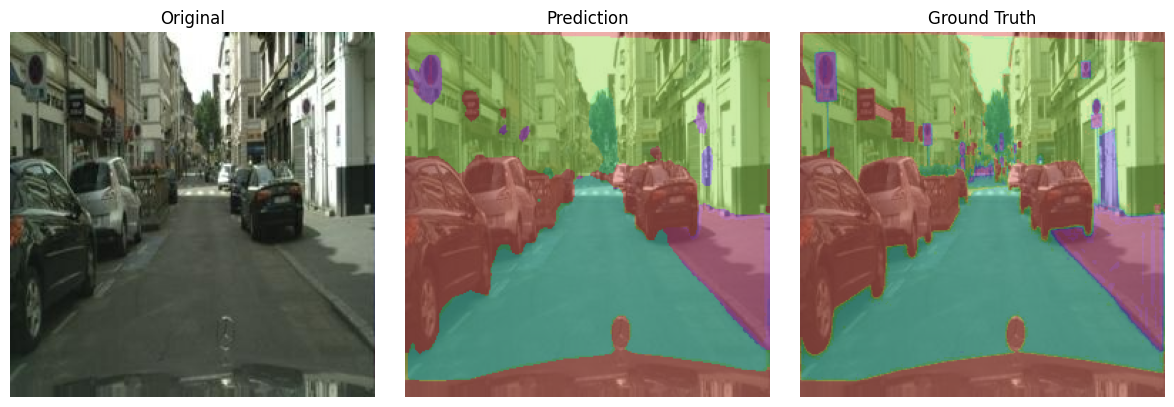

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


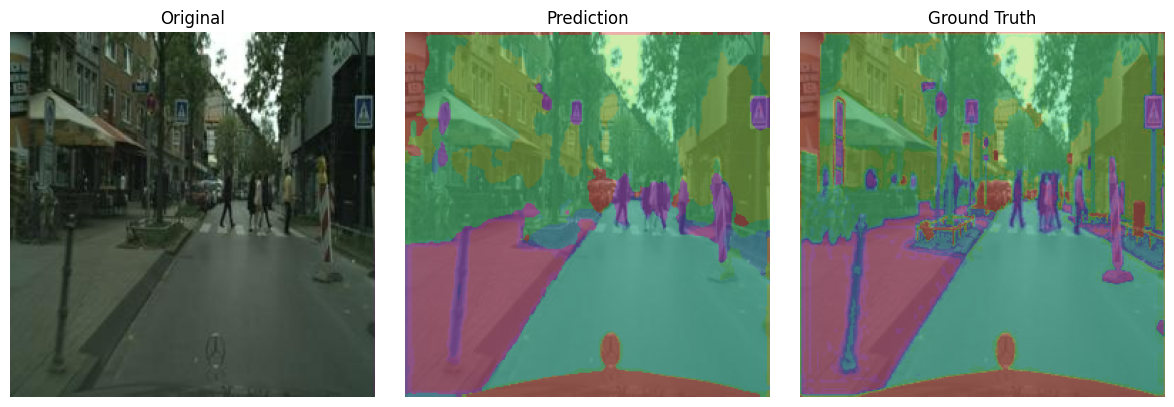

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


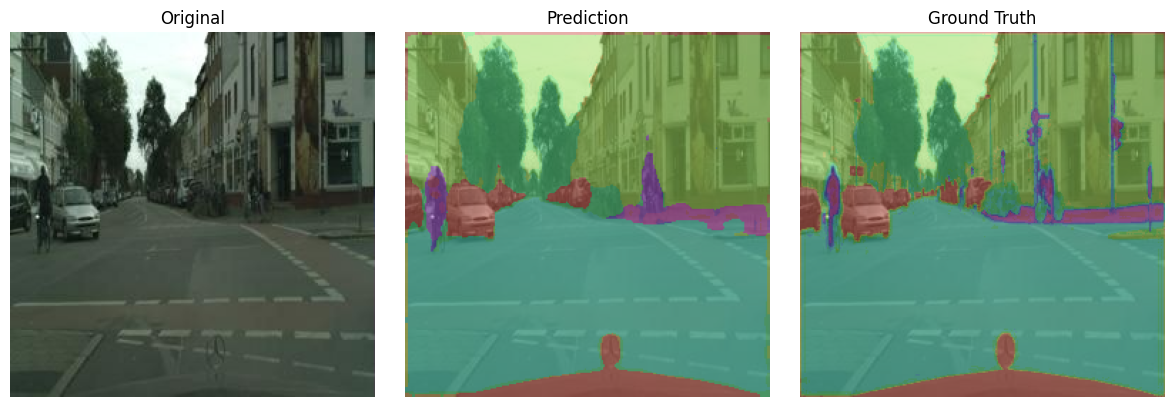

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


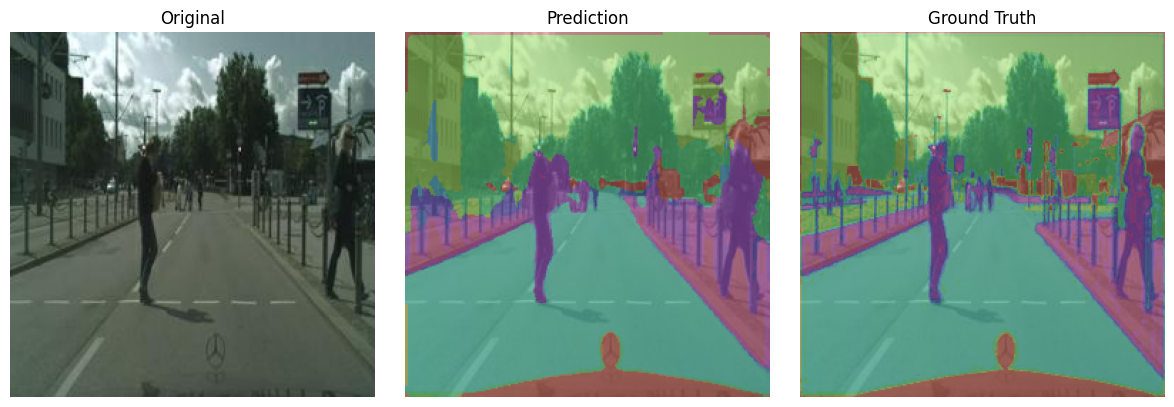

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


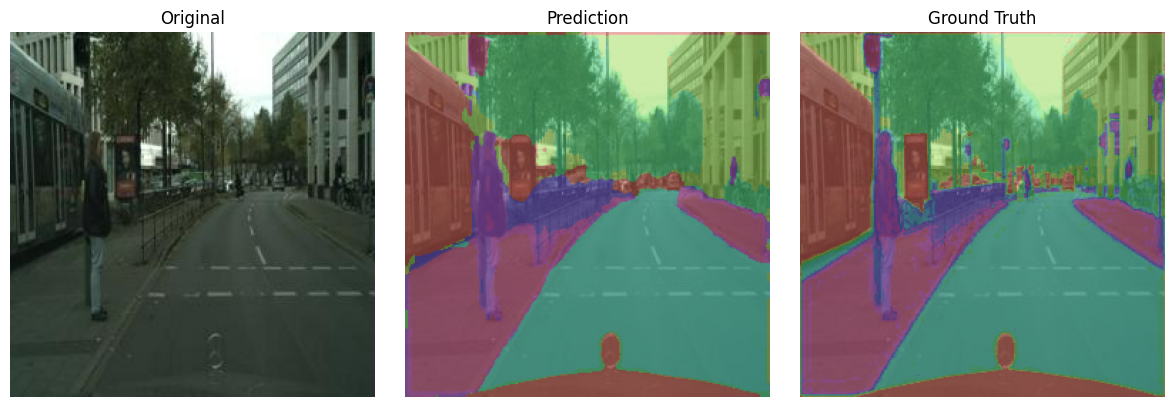

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


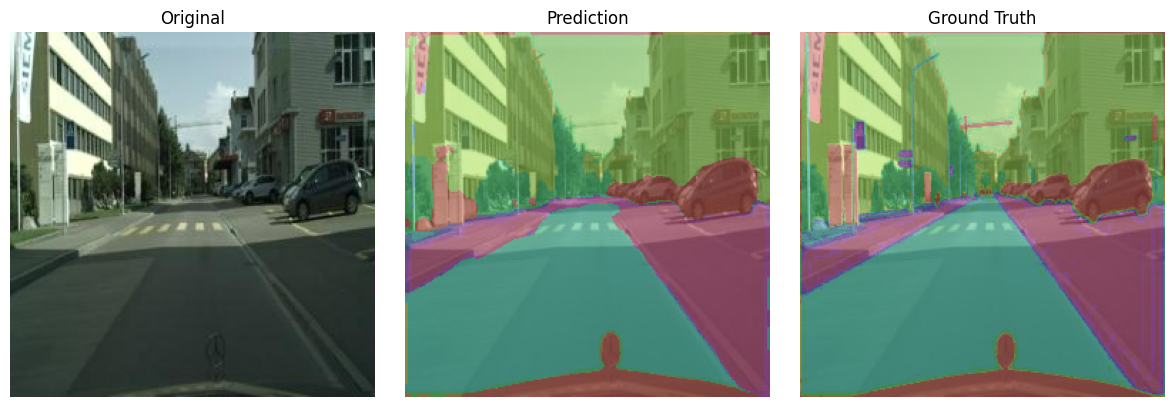

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


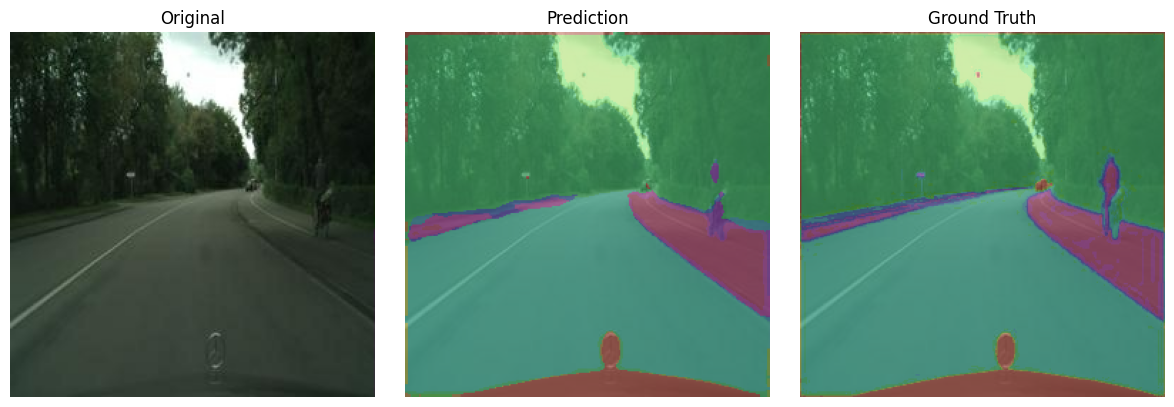

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


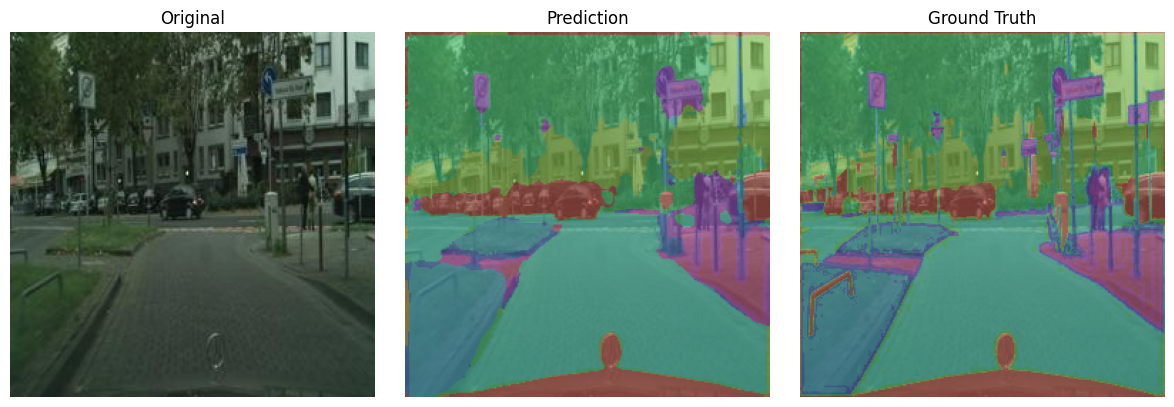

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


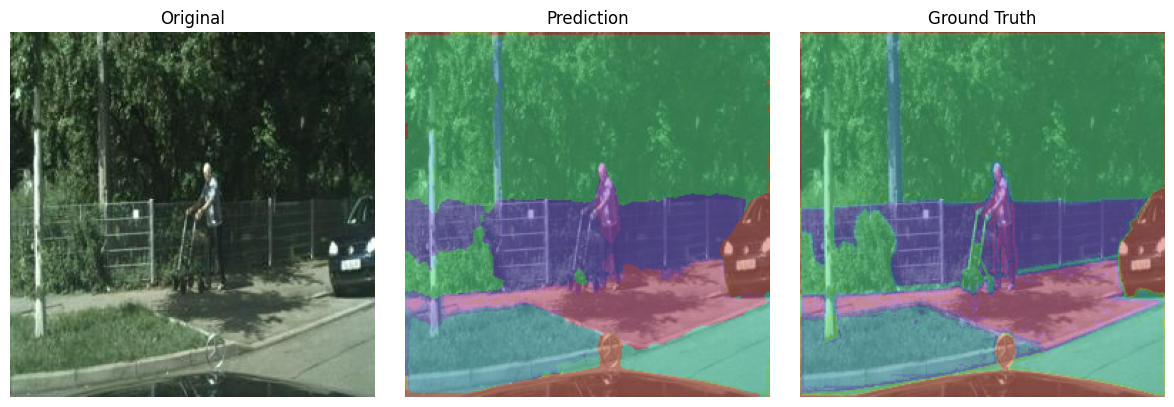

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


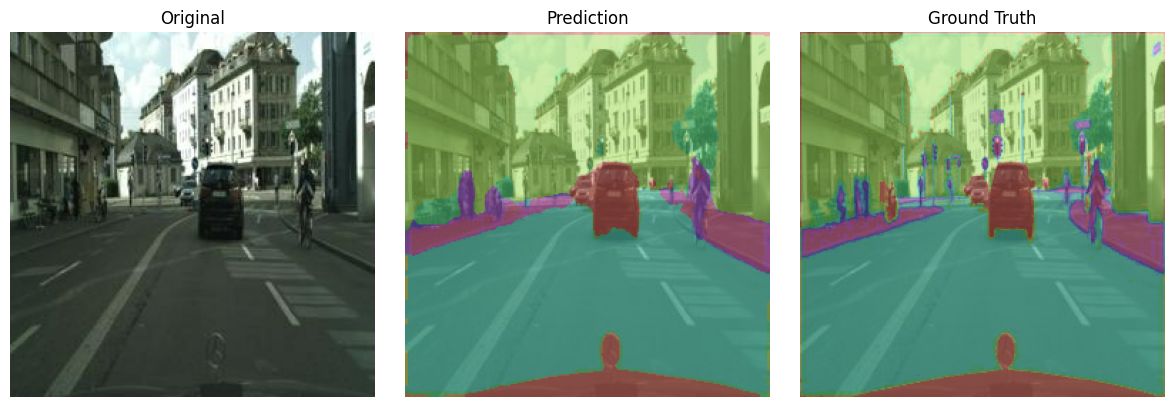

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


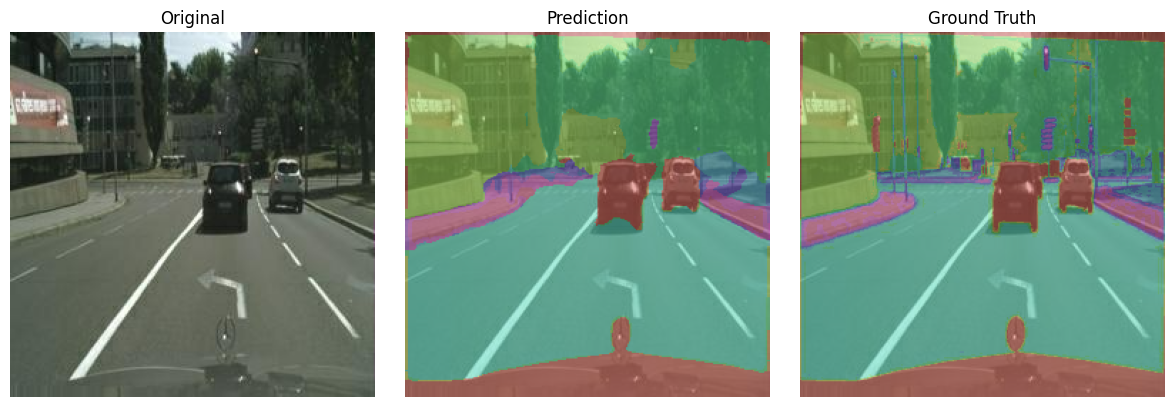

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


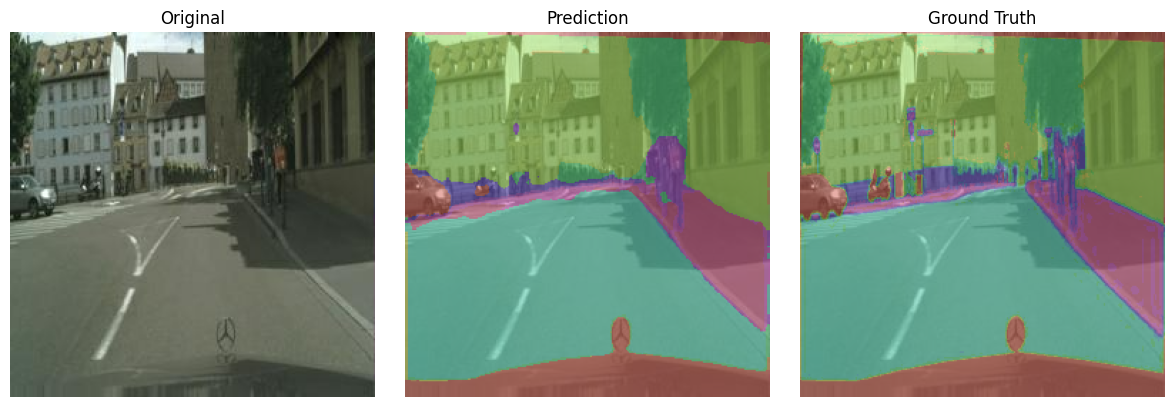

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


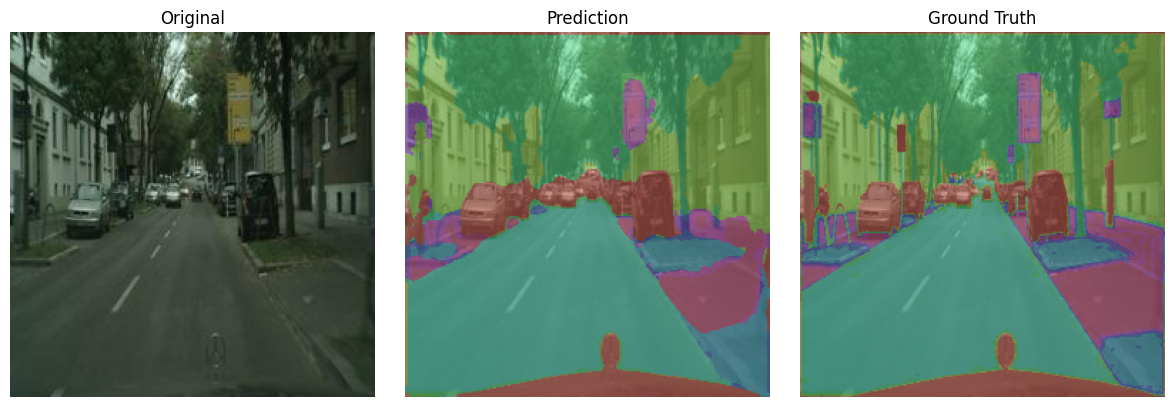

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


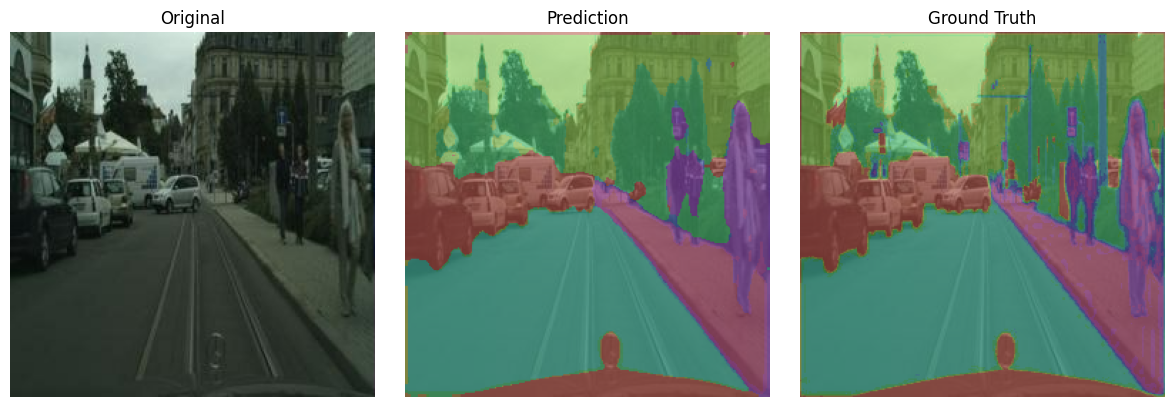

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


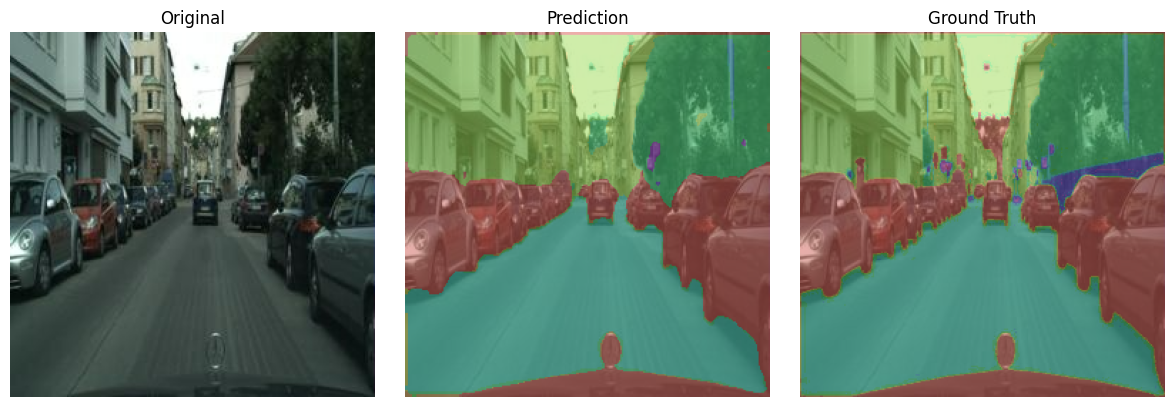

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


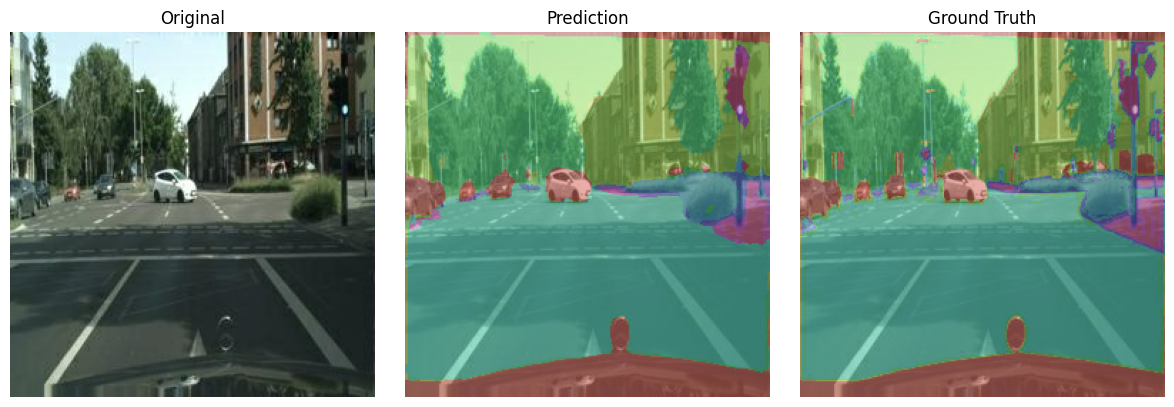

In [10]:
test_iter = iter(train_dataset)

for i in range(16):
    imgs, segs = next(test_iter)  # imgs: (B, H, W, 3), segs: (B, H, W)
    
    img_np = imgs[0].numpy()
    seg_np = segs[0].numpy()
    
    # Model prediction
    pred = seg_b0.predict(imgs[:1])        # shape: (1, H, W, N_CLASSES)
    pred_mask = np.argmax(pred[0], axis=-1)
    
    # Color masks
    pred_colored = give_color_to_seg_img(pred_mask)
    true_colored = give_color_to_seg_img(seg_np)
    
    # Overlay
    pred_overlay = cv2.addWeighted(img_np.astype(np.float32), 0.5, pred_colored.astype(np.float32), 0.5, 0)
    true_overlay = cv2.addWeighted(img_np.astype(np.float32), 0.5, true_colored.astype(np.float32), 0.5, 0)

    # Plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_overlay)
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_overlay)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
